In [4]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, ranksums, spearmanr
from itertools import combinations
from statsmodels.stats.multitest import multipletests

from datetime import datetime

# Get current date formatted as yymmdd
formatted_date = datetime.now().strftime('%y%m%d')
clustering_resolution = 0.3

#os.chdir('/home/ak431480')

## Load data

In [2]:
adata = sc.read_h5ad('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_147180_cells_250813.h5ad')
adata.obs['type'] = adata.obs['type'].cat.reorder_categories(['PC','HSPC','CRPC'])

# Drop CRPCs
adata = adata[~(adata.obs['type'] == 'CRPC')]

# Drop Cycling cells
adata = adata[~(adata.obs['cell_type'] == 'Cycling cell')]

In [ ]:
adata.obs_names_make_unique()

# Create an empty column to hold cluster assignments
adata.obs['celltype_leiden'] = None  

# Iterate over all cell types
for ctype in tqdm(adata.obs['cell_type'].unique()):
    print(f'Processing {ctype}...')
    adata_subset = adata[adata.obs['cell_type'] == ctype].copy()
    
    # Compute neighbors and Leiden within this subset
    sc.pp.neighbors(adata_subset, use_rep='X_pca_harmony',random_state=24664712)
    sc.tl.leiden(adata_subset, resolution=0.3, key_added='leiden_tmp')
    
    # Map results back into the main object
    adata.obs.loc[adata_subset.obs_names, 'celltype_leiden'] = (
        ctype + '_' + adata_subset.obs['leiden_tmp'].astype(str)
    )


In [ ]:
# Drop cellular subtypes present with < 50 genes
drop_cell_subtypes = adata.obs['celltype_leiden'].value_counts()[adata.obs['celltype_leiden'].value_counts() < 50].index.to_list()

adata = adata[~(adata.obs['celltype_leiden'].isin(drop_cell_subtypes))]
n_types = len(adata.obs['celltype_leiden'].value_counts())
# Summary
print(f'{n_types} unique categories:')
adata.obs['celltype_leiden'].value_counts()

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

In [ ]:
adata.write('./scs_data_clustered_annotated_250611_cellular_subtypes_for_cell2location.h5ad')

In [ ]:
### Find clusters that are mostly from a single sample and most likely technological

obs_data = adata.obs.copy()

vcounts = obs_data['celltype_leiden'].value_counts()

results = []  # collect rows

for col in vcounts.index:
    samplecounts = (
        obs_data[obs_data['celltype_leiden'] == col]['sample']
        .value_counts(normalize=True)
    )
    top_pct = samplecounts.iloc[0]*100
    top_sample = samplecounts.index[0]
    results.append({
        'celltype_leiden': col,
        'top_sample': top_sample,
        'top_pct': top_pct,
        'n_unique_samples': len(samplecounts[samplecounts != 0])
    })

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index('celltype_leiden')

# Sort by descending top_pct
summary_df = summary_df.sort_values(by='top_pct', ascending=False)

sns.set_theme(style='white',font_scale=0.6,rc={
    'xtick.bottom': True,
    'ytick.left': True})

fig,ax = plt.subplots(figsize=(4,3))
sns.histplot(summary_df['top_pct'],binwidth=10, kde=True, ax=ax)
ax.spines[['top','right']].set_visible(False)
ax.axvline(x=75,linestyle='--', color='firebrick')
plt.show()

clusters_to_drop = summary_df[summary_df['top_pct'] > 75].index.tolist()
summary_df.loc[clusters_to_drop]


In [ ]:
# Drop the clusters
adata = adata[~(adata.obs['celltype_leiden'].isin(clusters_to_drop))]

In [ ]:
adata.obs['celltype_leiden'].value_counts()

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

In [ ]:
# Save the adata object
adata.write(f'/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_{formatted_date}.h5ad')

## Calculate differential expression

In [ ]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()

In [ ]:
# One cluster vs all rest

output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers_vs_baseline_of_all_other.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}
category_results = []
# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    deg_results_df['annotation'] = g  # mark which group this came from
    category_results.append(deg_results_df)

combined_df = pd.concat(category_results, ignore_index=True)
combined_df.to_excel(writer, sheet_name='DEGs', index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


In [ ]:
output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}

# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'
    marker_genes_dict[g] = top_genes_str

# Second pass: within-category DEGs
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:
    celltype_groups = [c for c in celltypes if top_category in c]

    adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
    sc.tl.rank_genes_groups(
        adata,
        groupby='celltype_leiden',
        groups=celltype_groups,
        reference='rest',
        layer='log1p',
        use_raw=False
    )

    category_results = []

    for g in celltype_groups:
        deg_results_df = sc.get.rank_genes_groups_df(adata, group=g, log2fc_min=1, pval_cutoff=0.05)
        deg_results_df['annotation'] = g  # mark which group this came from
        category_results.append(deg_results_df)

        # Update marker gene string
        marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'

    # Concatenate and save to Excel tab for this top_category
    if category_results:
        combined_df = pd.concat(category_results, ignore_index=True)
        combined_df.to_excel(writer, sheet_name=top_category[:31], index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


## Plot cluster markers on umap

In [ ]:
# Calculate the differentially expressed genes in each group, put them into a string
marker_genes_dict = {}

sc.tl.rank_genes_groups(scs_adata,
        groupby='celltype_leiden',
        reference='rest',
        layer='log1p',
        use_raw=False)

for g in celltypes:
        deg_results_df = sc.get.rank_genes_groups_df(scs_adata,group=g,log2fc_min=1,pval_cutoff=0.05)

        # Extract the genes with the top 3 highest scores
        top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'

        marker_genes_dict[g] = top_genes_str

# Second pass, markers for within the celltype group
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:

        celltype_groups = [c for c in celltypes if top_category in c]

        adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
        sc.tl.rank_genes_groups(adata,
                groupby='celltype_leiden',
                groups=celltype_groups,
                reference='rest',
                layer='log1p',
                use_raw=False)

        for g in celltype_groups:
                deg_results_df = sc.get.rank_genes_groups_df(adata,group=g,log2fc_min=1,pval_cutoff=0.05)

                # Extract the genes with the top 3 highest scores
                marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'


In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# ensure UMAP is computed
if 'X_umap' not in scs_adata.obsm:
    sc.tl.umap(scs_adata)

# extract coordinates
umap = scs_adata.obsm['X_umap']
clusters = scs_adata.obs['celltype_leiden'].cat.categories

# set up grid
fig, axes = plt.subplots(9, 5, figsize=(12, 20))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    highlight = scs_adata.obs['celltype_leiden'] == cluster

    # plot all cells in lightgray
    ax.scatter(umap[:, 0], umap[:, 1], s=0.1, color='lightgray', alpha=0.5, rasterized=True)
    # plot highlighted cluster in firebrick
    ax.scatter(umap[highlight, 0], umap[highlight, 1], s=0.1, color='firebrick', rasterized=True)

    ax.set_title(str(cluster) + ' ' + marker_genes_dict[cluster], fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# turn off extra axes if < 21 clusters
for j in range(len(clusters), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('/home/ak431480/shafi_explant_project/plots/scs_celltype_leiden_separately_highted_on_umap.pdf')
plt.show()


## Plot celltype fractions by treatment

In [5]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
scs_adata.obs_names = scs_adata.obs['sample'].astype(str) + '_' + scs_adata.obs_names

adata = scs_adata[scs_adata.obs['cell_type'] == 'Epithelial cell']

celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()



In [8]:
prostate_lineage_signatures_dict = {}
prostate_lineage_signatures = pd.read_excel('/home/ak431480/prostate_lineage_signatures.xlsx',skiprows=1)
for gset in tqdm(prostate_lineage_signatures.columns):
    if 'Lum–' in gset:
        sig = prostate_lineage_signatures['Luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if 'dLum' in gset:
        sig = prostate_lineage_signatures['Duct luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if '_Basal' in gset:
        sig = prostate_lineage_signatures['Basal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    else:
        sig = prostate_lineage_signatures[gset].dropna().tolist()
    sc.tl.score_genes(adata,sig,score_name=gset,use_raw=False,layer='log1p')
    prostate_lineage_signatures_dict[gset] = prostate_lineage_signatures[gset].dropna().tolist()

celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()

  0%|          | 0/46 [00:00<?, ?it/s]/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
  2%|▏         | 1/46 [00:14<11:12, 14.95s/it]

 11%|█         | 5/46 [00:18<01:24,  2.07s/it]

 33%|███▎      | 15/46 [00:26<00:26,  1.16it/s]

 37%|███▋      | 17/46 [00:28<00:24,  1.18it/s]

 50%|█████     | 23/46 [00:33<00:19,  1.18it/s]

 54%|█████▍    | 25/46 [00:35<00:17,  1.17it/s]

 59%|█████▊    | 27/46 [00:37<00:18,  1.04it/s]

 61%|██████    | 28/46 [00:38<00:20,  1.11s/it]

 65%|██████▌   | 30/46 [00:40<00:16,  1.06s/it]

 67%|██████▋   | 31/46 [00:41<00:15,  1.01s/it]

 70%|██████▉   | 32/46 [00:42<00:13,  1.04it/s]

       'IFNA14', 'IFNA13', 'IFNA17', 'IFNA4', 'CCL3L3', 'IL9'],
      dtype='object')


 72%|███████▏  | 33/46 [00:43<00:12,  1.07it/s]

 74%|███████▍  | 34/46 [00:44<00:12,  1.04s/it]

 78%|███████▊  | 36/46 [00:46<00:10,  1.01s/it]

 80%|████████  | 37/46 [00:48<00:09,  1.10s/it]

 83%|████████▎ | 38/46 [00:49<00:08,  1.09s/it]

 85%|████████▍ | 39/46 [00:50<00:08,  1.18s/it]

 87%|████████▋ | 40/46 [00:51<00:06,  1.14s/it]

 91%|█████████▏| 42/46 [00:54<00:04,  1.18s/it]

 93%|█████████▎| 43/46 [00:55<00:03,  1.10s/it]

100%|██████████| 46/46 [00:57<00:00,  1.25s/it]
/tmp/ipykernel_756615/3143398565.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()


In [14]:
# Only keep cells with a positive CNV status
concat_obs_data = pd.read_csv('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/epithelial_cancer_cell_annotation_20250818.csv',index_col=0)
concat_obs_data.index =  concat_obs_data['sample'].astype(str) + '_' + concat_obs_data.index
cnv_adata = scs_adata[scs_adata.obs_names.isin(concat_obs_data[concat_obs_data['CNV_status'] == 'CNVpos cancer'].index.tolist())].copy()
adata.obs = pd.merge(adata.obs,concat_obs_data[['CNV_status']],left_index=True,right_index=True,how='left')
adata.obs['CNV_status'] = adata.obs['CNV_status'].fillna('Benign')

/tmp/ipykernel_756615/834032855.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', grpby, 'celltype_leiden'])
/tmp/ipykernel_756615/834032855.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
/tmp/ipykernel_756615/834032855.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts.groupby('celltype_leiden')['fracti

      celltype_leiden  n_HSPC  n_PC      pval  pval_adj
0   Epithelial cell_5      18    10  0.000130  0.001296
1   Epithelial cell_6      18    10  0.000015  0.000152
2   Epithelial cell_9      18    10  1.000000  1.000000
3   Epithelial cell_2      18    10  0.000724  0.007243
4   Epithelial cell_1      18    10  0.002330  0.023300
5   Epithelial cell_0      18    10  0.000041  0.000414
6   Epithelial cell_4      18    10  0.010314  0.103138
7  Epithelial cell_11      18    10  0.022512  0.225122
8   Epithelial cell_7      18    10  0.221406  1.000000
9   Epithelial cell_3      18    10  0.005835  0.058350


/tmp/ipykernel_756615/834032855.py:83: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(
/tmp/ipykernel_756615/834032855.py:83: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_756615/834032855.py:83: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  sns.pointplot(


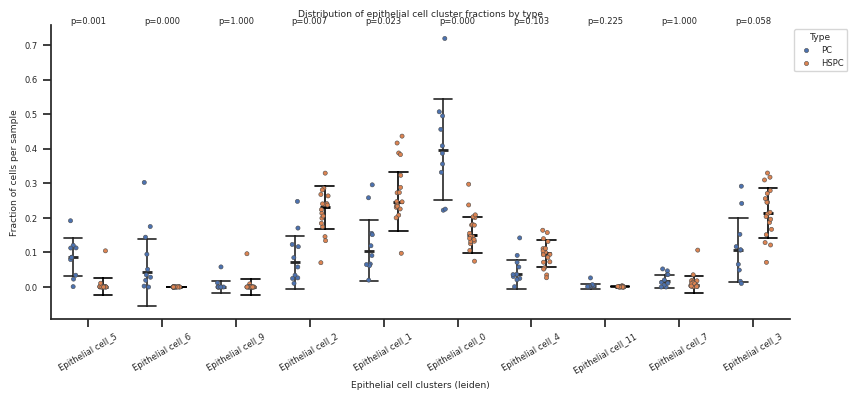

In [15]:
from scipy.stats import mannwhitneyu
ctype = 'Epithelial cell'
grpby = 'type'

sns.set_theme(style='white', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

# Copy and filter data
obs_data = adata.obs.copy()

obs_data = obs_data[obs_data['cell_type'] == ctype].copy()
obs_data['celltype_leiden'] = obs_data['celltype_leiden'].cat.remove_unused_categories()

vcounts = obs_data['sample'].value_counts()
obs_data = obs_data[obs_data['sample'].isin(vcounts[vcounts >=100].index)]
obs_data['sample'] = obs_data['sample'].cat.remove_unused_categories()

# Compute per-sample fractions
sample_counts = (
    obs_data
    .groupby(['sample', grpby, 'celltype_leiden'])
    .size()
    .reset_index(name='count')
)

# Normalize within each sample
sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
sample_counts['fraction'] = sample_counts['count'] / sample_totals

sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^HSPC_')) & (sample_counts['type'] == 'PC'))]
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^PC_')) & (sample_counts['type'] == 'HSPC'))]

# Sort celltypes by mean abundance
mean_fractions = (
    sample_counts.groupby('celltype_leiden')['fraction']
    .mean()
    .sort_values(ascending=False)
)

# ---- Statistical test per celltype_leiden ----
types = sample_counts[grpby].unique()
if len(types) != 2:
    raise ValueError(f"Expected exactly 2 types, found: {types}")

pvals = []
for celltype in celltype_order:
    data_sub = sample_counts[sample_counts['celltype_leiden'] == celltype]
    group1 = data_sub.loc[data_sub[grpby] == types[0], 'fraction'].dropna()
    group2 = data_sub.loc[data_sub[grpby] == types[1], 'fraction'].dropna()

    # Only test if both groups have >1 value
    if len(group1) > 0 and len(group2) > 0:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    else:
        p = np.nan
    pvals.append({'celltype_leiden': celltype,
                  'n_' + types[0]: len(group1),
                  'n_' + types[1]: len(group2),
                  'pval': p})

pval_df = pd.DataFrame(pvals)
pval_df['pval_adj'] = pval_df['pval'] * len(pval_df)  # Bonferroni
pval_df['pval_adj'] = pval_df['pval_adj'].clip(upper=1.0)

print(pval_df)

# ---- Boxplot ----
plt.figure(figsize=(8, 4))
sns.stripplot(
    data=sample_counts,
    x='celltype_leiden',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    dodge=True,
    #fliersize=0.5,
    linewidth=0.4,
    size=3,
)

sns.pointplot(
    data=sample_counts,
    x='celltype_leiden',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    errorbar='sd',
    estimator='median',
    dodge=0.4,        # must match stripplot hue separation
    join=False,
    capsize=0.25,
    errwidth=1.2,
    markers='_',
    linestyles='',
    color='black',   # darker lines for contrast
    legend=False      # avoid double legend
)
# Annotate p-values above boxes
y_max = sample_counts['fraction'].max()
for i, row in enumerate(pval_df.itertuples()):
    label = f"p={row.pval_adj:.3f}" if not np.isnan(row.pval_adj) else "n/a"
    plt.text(i, y_max * 1.05, label, ha='center', va='bottom', fontsize=6)

plt.xlabel('Epithelial cell clusters (leiden)')
plt.ylabel('Fraction of cells per sample')
plt.title('Distribution of epithelial cell cluster fractions by type')
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


### Dotplot for gene markers

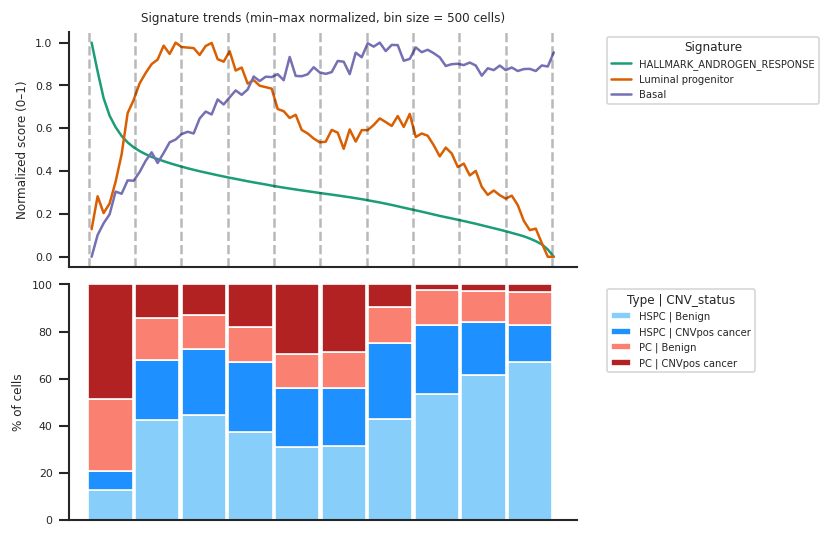

In [18]:
# --- Parameters ---
bin_size = 500  # 🔧 adjust this to control smoothing window
n_quantiles = 10

signatures = [
    'HALLMARK_ANDROGEN_RESPONSE',
    #'Prostate_progenitor',
    #'Luminal',
    'Prostate_progenitor',
    'Basal',
    #'TISS',
    #'Duct luminal',
    #'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
    #'HALLMARK_INTERFERON_ALPHA_RESPONSE'
    
]


# --- Sort cells by the key signature ---
order = adata.obs['HALLMARK_ANDROGEN_RESPONSE'].sort_values(ascending=False).index

# --- Create decile vector (0–9) based on sorted order ---
decile_labels = pd.qcut(range(len(order)), n_quantiles , labels=False) + 1
adata.obs.loc[order, 'decile'] = decile_labels.astype(int)

# --- Define bins based on chosen bin size ---
adata.obs.loc[order, 'bin'] = (np.arange(len(order)) // bin_size).astype(int)

# --- Compute mean per bin for selected signatures ---
binned_means = (
    adata.obs.loc[order]
    .groupby('bin')[signatures]
    .mean()
    .reset_index()
)
binned_means['rank'] = binned_means['bin'] * bin_size + bin_size / 2  # midpoint of bin


# --- Min–max normalize each signature ---
binned_means_norm = binned_means.copy()
for sig in signatures:
    min_val = binned_means[sig].min()
    max_val = binned_means[sig].max()
    if max_val > min_val:
        binned_means_norm[sig] = (binned_means[sig] - min_val) / (max_val - min_val)
    else:
        binned_means_norm[sig] = 0.5  # handle flat signals gracefully

binned_means_norm['sum'] = binned_means_norm[signatures].sum(axis=1)

# --- Reshape for plotting ---
binned_long = binned_means_norm.melt(
    id_vars='rank',
    value_vars=signatures,# + ['sum'],
    var_name='signature',
    value_name='normalized_value'
)

# --- Combine 'type' and 'CNV_status' into one column ---
adata.obs['type_CNV'] = adata.obs['type'].astype(str) + ' | ' + adata.obs['CNV_status'].astype(str)

# --- Compute fractions per decile for the combined category ---
def compute_fractions(df, group_col):
    frac = (
        df.groupby(['decile', group_col])
        .size()
        .reset_index(name='count')
    )
    frac['fraction'] = frac['count'] / frac.groupby('decile')['count'].transform('sum') * 100
    frac_wide = frac.pivot(index='decile', columns=group_col, values='fraction').fillna(0)
    frac_wide['rank'] = frac_wide.index
    return frac_wide

combined_fraction = compute_fractions(adata.obs, 'type_CNV')

binned_long['signature'] = binned_long['signature'].replace({'Prostate_progenitor': 'Luminal progenitor'})

# --- Plot setup ---
sns.set_theme(style='white', palette='Dark2', font_scale=0.6, rc={'xtick.bottom': True, 'ytick.left': True})
fig, ax = plt.subplots(2, 1, figsize=(7, 4.5), sharex=False,dpi=120)

# --- Plot all normalized signatures on same scale ---
sns.lineplot(
    data=binned_long,
    x='rank',
    y='normalized_value',
    hue='signature',
    lw=1.5,
    ax=ax[0]
)
ax[0].set_ylabel('Normalized score (0–1)')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[0].legend(title='Signature', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
ax[0].spines[['top', 'right']].set_visible(False)
ax[0].set_xticks([])
ax[0].set_title(f'Signature trends (min–max normalized, bin size = {bin_size} cells)')
for q in np.arange(0,1.1,1/n_quantiles):
    ax[0].axvline(q*len(adata),linestyle='--',color='k',alpha=0.3)

#ax[0].axhline(y = binned_means_norm['sum'].max())

sns.set_theme(style='white', palette=sns.color_palette(['lightskyblue','dodgerblue','salmon','firebrick',]), font_scale=0.6, rc={'xtick.bottom': True, 'ytick.left': True})
# --- Stacked barplot for combined 'type|CNV_status' ---
combined_fraction.plot(
    x='rank',
    kind='bar',
    stacked=True,
    ax=ax[1],
    width=0.95
)

ax[1].set_ylabel('% of cells')
ax[1].set_xlabel('Decile of HALLMARK_ANDROGEN_RESPONSE (descending)')
ax[1].set_xlabel('')
ax[1].set_xticklabels([])
ax[1].set_xticks([])
ax[1].set_ylim(0, 100)
ax[1].set_xlim(-0.9,n_quantiles)
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, title='Type | CNV_status')

plt.tight_layout()
plt.savefig('/home/ak431480/plots/signature_CNV_plot.pdf')
plt.show()


/tmp/ipykernel_756615/3345455277.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', grpby, 'decile'])
/tmp/ipykernel_756615/3345455277.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
/tmp/ipykernel_756615/3345455277.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts.groupby('decile')['fraction']


   decile  n_HSPC  n_PC      pval  pval_adj significance
0     1.0      18    10  0.000425  0.004250           **
1     2.0      18    10  0.486916  0.486916           ns
2     3.0      18    10  0.302613  0.361841           ns
3     4.0      18    10  0.325657  0.361841           ns
4     5.0      18    10  0.240121  0.343030           ns
5     6.0      18    10  0.017628  0.035256            *
6     7.0      18    10  0.001430  0.005622           **
7     8.0      18    10  0.001687  0.005622           **
8     9.0      18    10  0.015466  0.035256            *
9    10.0      18    10  0.022741  0.037901            *


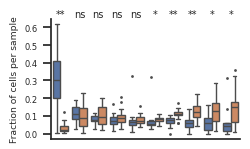

In [19]:
from scipy.stats import mannwhitneyu

ctype = 'Epithelial cell'
grpby = 'type'

sns.set_theme(style='white', font_scale=0.55, rc={
    'xtick.bottom': False,
    'ytick.left': True
})

# --- Copy and filter data ---
obs_data = adata.obs.copy()
obs_data = obs_data[obs_data['cell_type'] == ctype].copy()
obs_data['decile'] = pd.Categorical(obs_data['decile'])

# Remove low-cell samples
vcounts = obs_data['sample'].value_counts()
obs_data = obs_data[obs_data['sample'].isin(vcounts[vcounts >= 100].index)]
obs_data['sample'] = obs_data['sample'].cat.remove_unused_categories()

# --- Compute per-sample fractions ---
sample_counts = (
    obs_data
    .groupby(['sample', grpby, 'decile'])
    .size()
    .reset_index(name='count')
)

# Normalize within each sample
sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
sample_counts['fraction'] = sample_counts['count'] / sample_totals

# Clean mismatched sample-type combos
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^HSPC_')) & (sample_counts['type'] == 'PC'))]
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^PC_')) & (sample_counts['type'] == 'HSPC'))]

# --- Sort celltypes by mean abundance ---
mean_fractions = (
    sample_counts.groupby('decile')['fraction']
    .mean()
    .sort_values(ascending=False)
)

# --- Statistical test per decile ---
types = sample_counts[grpby].unique()
if len(types) != 2:
    raise ValueError(f"Expected exactly 2 types, found: {types}")

pvals = []
for dec in obs_data['decile'].cat.categories:
    data_sub = sample_counts[sample_counts['decile'] == dec]
    group1 = data_sub.loc[data_sub[grpby] == types[0], 'fraction'].dropna()
    group2 = data_sub.loc[data_sub[grpby] == types[1], 'fraction'].dropna()

    if len(group1) > 0 and len(group2) > 0:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    else:
        p = np.nan
    pvals.append({'decile': dec,
                  f'n_{types[0]}': len(group1),
                  f'n_{types[1]}': len(group2),
                  'pval': p})

pval_df = pd.DataFrame(pvals)

# --- BH (Benjamini–Hochberg) correction ---
reject, pvals_corrected, _, _ = multipletests(pval_df['pval'], method='fdr_bh')
pval_df['pval_adj'] = pvals_corrected

# --- Convert adjusted p-values to significance stars ---
def p_to_star(p):
    if np.isnan(p):
        return "n/a"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

pval_df['significance'] = pval_df['pval_adj'].apply(p_to_star)
print(pval_df)

# --- Plot ---
plt.figure(figsize=(2.5, 1.5))

# Pointplot for median ± SD
sns.boxplot(
    data=sample_counts,
    x='decile',
    y='fraction',
    hue=grpby,
    dodge=0.4,
    fliersize=1,
    legend=False
)

# --- Annotate significance above each decile ---
y_max = sample_counts['fraction'].max()
for i, row in enumerate(pval_df.itertuples()):
    plt.text(i, y_max * 1.05, row.significance, ha='center', va='bottom', fontsize=7)

#plt.xlabel('HALLMARK AR deciles')
plt.xlabel('')
plt.ylabel('Fraction of cells per sample')
plt.xticks([],rotation=30)
sns.despine()
plt.tight_layout()
plt.savefig('/home/ak431480/plots/sample_fractions_boxplot.pdf')
plt.show()


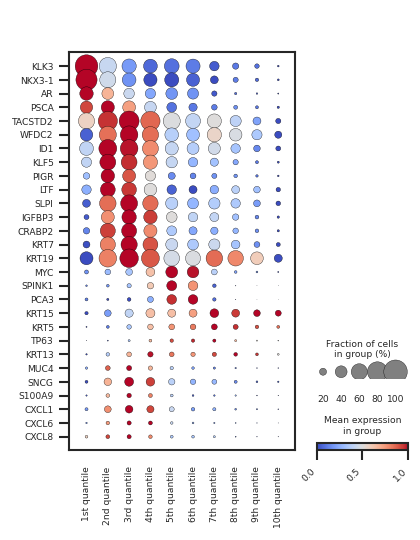

In [20]:
gene_markers = [
    'KLK3','NKX3-1','AR',
    'PSCA','TACSTD2','WFDC2','ID1','KLF5',
    'PIGR','LTF','SLPI',
    'IGFBP3','CRABP2','KRT7','KRT19',
    'MYC','SPINK1','PCA3',
    'KRT15', 'KRT5', 'TP63',
    'KRT13','MUC4','SNCG','S100A9',
    'CXCL1','CXCL6','CXCL8'
]


# --- Ensure decile_cat is categorical and ordered ---
adata.obs['decile_cat'] = pd.Categorical(adata.obs['decile'], ordered=True)


# --- Rename categories for nice labels ---
decile_labels = [
    f'{i+1}{"st" if i==0 else "nd" if i==1 else "rd" if i==2 else "th"} quantile'
    for i in range(len(adata.obs['decile_cat'].cat.categories))
]
adata.obs['decile_cat'] = adata.obs['decile_cat'].cat.rename_categories(decile_labels)

# --- Plot ---
fig, ax = plt.subplots(figsize=(3.5, 4.5), dpi=120)
sc.pl.dotplot(
    adata,
    groupby='decile_cat',
    var_names=gene_markers,
    standard_scale='var',
    cmap='coolwarm',
    use_raw=False,
    layer='log1p',
    swap_axes=True,
    var_group_rotation=45,
    dot_max=1,
    ax=ax,
    show=False
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('/home/ak431480/plots/dotplot_sorted.pdf')
plt.show()

/tmp/ipykernel_756615/3500279414.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expr = expr.groupby('decile_cat').mean()


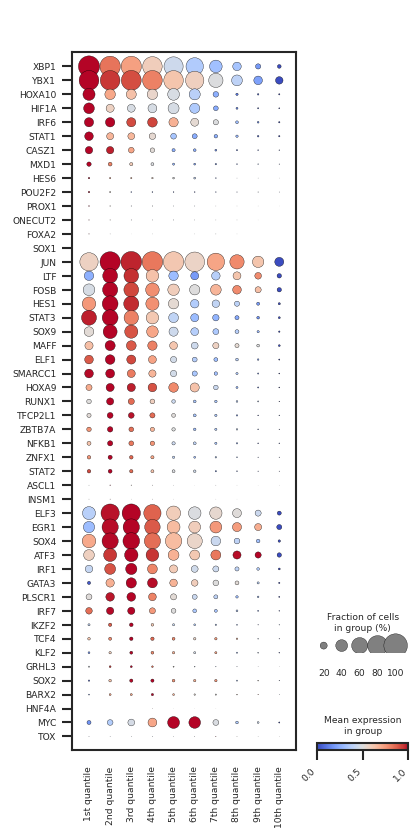

In [21]:
# Chan et al. Science 2022
gene_markers = [
    "HIF1A", "FOSB", "NFKB1", "IRF6", "HES1", "MAFF", "JUN", "RUNX1", "ATF3", # Transtition
    "ELF1", "MYC", "EGR1", "ZBTB7A", "SOX9", "IKZF2", "KLF2", "PLSCR1", # Transtition
    "GRHL3", "BARX2", "STAT1", "IRF7", "TFCP2L1", "ZNFX1", "MXD1", "LTF", # Transtition
    "HNF4A", "IRF1", "CASZ1", "ELF3", "STAT2", "XBP1", "SOX4", "ONECUT2", # Transtition
    "STAT3", "SOX2", "SOX1", "FOXA2", "TOX", "PROX1", "HOXA10", "TCF4", # NEPC
    "YBX1", "INSM1", "HOXA9", "ASCL1", "HES6", "SMARCC1", "POU2F2", "GATA3",# NEPC
]
gene_markers = pd.Series(gene_markers)[adata[:,gene_markers].X.mean(axis=0).argsort()[::-1]].tolist()#[:15]

# --- Ensure decile_cat is categorical and ordered ---
adata.obs['decile_cat'] = pd.Categorical(adata.obs['decile'], ordered=True)

# Compute average expression per gene per decile
expr = pd.DataFrame(
    adata[:, gene_markers].to_df(layer='log1p'),
    index=adata.obs_names,
    columns=gene_markers
)
expr['decile_cat'] = adata.obs['decile_cat'].values
mean_expr = expr.groupby('decile_cat').mean()

# Determine decile where each gene is maximally expressed
peak_decile = mean_expr.idxmax(axis=0)
# Sort genes first by decile order, then by mean value within that decile
gene_markers_sorted = (
    pd.DataFrame({
        'gene': peak_decile.index,
        'peak_decile': peak_decile.values,
        'peak_value': [mean_expr.loc[peak_decile[g], g] for g in peak_decile.index]
    })
    .sort_values(['peak_decile', 'peak_value'], ascending=[True, False])
    ['gene']
    .tolist()
)

# --- Rename categories for nice labels ---
decile_labels = [
    f'{i+1}{"st" if i==0 else "nd" if i==1 else "rd" if i==2 else "th"} quantile'
    for i in range(len(adata.obs['decile_cat'].cat.categories))
]
adata.obs['decile_cat'] = adata.obs['decile_cat'].cat.rename_categories(decile_labels)

# --- Plot ---
fig, ax = plt.subplots(figsize=(3.5, 7), dpi=120)
sc.pl.dotplot(
    adata,
    groupby='decile_cat',
    var_names=gene_markers_sorted,
    standard_scale='var',
    cmap='coolwarm',
    use_raw=False,
    layer='log1p',
    swap_axes=True,
    var_group_rotation=45,
    dot_max=1,
    ax=ax,
    show=False
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('/home/ak431480/plots/chan_2022_tfs_dotplot_sorted.pdf')
plt.show()

In [22]:
# Ensure decile is categorical for grouping
adata.obs['decile_cat'] = pd.Categorical(adata.obs['decile'])

# Compute top genes per decile
sc.tl.rank_genes_groups(
    adata,
    groupby='decile_cat',
    method='t-test',   # can also use 'wilcoxon' or 'logreg'
    use_raw=False,
    layer='log1p'
)


deg_df = sc.get.rank_genes_groups_df(adata,log2fc_min=0.5, pval_cutoff=0.05,group=None)


In [24]:
deg_df[deg_df['names'].isin(['AMACR','TACSTD2','KRT5','KRT15','TP63'])]
#deg_df[deg_df['names'].isin(prostate_lineage_signatures_dict['HALLMARK_INTERFERON_ALPHA_RESPONSE'])]['group'].value_counts()
#deg_df[deg_df['group'].isin(['3.0'])][:50]

,group,names,scores,logfoldchanges,pvals,pvals_adj
3761,1.0,AMACR,10.461302,1.089551,2.648893e-25,1.702878e-24
10201,2.0,TACSTD2,31.448185,1.162766,1.852965e-198,3.060422e-196
22295,3.0,TACSTD2,34.814697,1.289338,3.935652e-238,7.950320e-235
33188,4.0,TACSTD2,22.786655,0.921318,2.788925e-109,4.882664e-106
34559,4.0,AMACR,7.862656,0.690541,4.656115e-15,6.358514e-14
37822,5.0,AMACR,15.027350,1.127183,6.957871e-50,3.150356e-47
37895,5.0,TP63,6.490261,0.786923,9.467966e-11,5.599961e-09
38136,6.0,AMACR,9.659327,0.677107,6.863836e-22,6.089567e-20
38169,6.0,TP63,6.719697,0.861021,2.048409e-11,6.381170e-10
38341,7.0,KRT15,11.286693,0.762198,3.767872e-29,3.035217e-27


In [26]:
obs_data = adata.obs.copy()
sig = 'CRPC-SCL'#'HALLMARK_INTERFERON_ALPHA_RESPONSE'
obs_data[['decile_cat',sig]].groupby('decile_cat').median().sort_values(sig,ascending=False)

/tmp/ipykernel_756615/3571368614.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_data[['decile_cat',sig]].groupby('decile_cat').median().sort_values(sig,ascending=False)


,CRPC-SCL
decile_cat,
3.0,0.238997
2.0,0.218687
4.0,0.197229
7.0,0.108540
1.0,0.094888
5.0,0.089769
8.0,0.077674
6.0,0.063394
9.0,0.046035


### Save the single cell annotation with AR_HM quantile annotation

In [13]:
decile_cat = 'Epithelial cell_' + adata.obs['decile_cat'].astype(str)

scs_adata.obs['celltype_leiden'] = (
    scs_adata.obs['celltype_leiden']
    .cat.add_categories(decile_cat.unique())
)

scs_adata.obs.loc[decile_cat.index, 'celltype_leiden'] = decile_cat
scs_adata.obs['celltype_leiden'] = scs_adata.obs['celltype_leiden'].cat.remove_unused_categories()
scs_adata.obs

,doublet,doublet_score,sample,type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,celltype_leiden
HSPC_S07_AGCGGTCAGACTAGAT-1,0.0,10.678799,HSPC_S07,HSPC,4277,11896,1044,8.776059,4,Endothelial cell,Endothelial cell_0
HSPC_S07_CTACACCTCACCATAG-1,0.0,10.678799,HSPC_S07,HSPC,3434,7854,748,9.523810,4,Endothelial cell,Endothelial cell_0
HSPC_S07_ACCAGTAGTCGCGAAA-1,0.0,10.678799,HSPC_S07,HSPC,3782,7683,722,9.397371,4,Endothelial cell,Endothelial cell_2
HSPC_S07_CATCAGAAGGCACATG-1,0.0,2.938393,HSPC_S07,HSPC,1420,4490,447,9.955457,12,Epithelial cell,Epithelial cell_8.0
HSPC_S07_CATTATCTCGCAAACT-1,0.0,2.938393,HSPC_S07,HSPC,407,991,94,9.485368,12,Epithelial cell,Epithelial cell_10.0
...,...,...,...,...,...,...,...,...,...,...,...
PC_S44_GGGAGATGTAGAAAGG-1-1,0.0,26.731888,PC_S44,PC,423,1042,64,6.142035,1,Epithelial cell,Epithelial cell_1.0
PC_S44_GAGTCCGGTCCGAAGA-1-1,0.0,0.554882,PC_S44,PC,382,715,65,9.090909,21,Myeloid cell,Myeloid cell_3
PC_S44_GTACTTTGTTCCCTTG-1-3,0.0,26.731888,PC_S44,PC,465,665,65,9.774436,1,Epithelial cell,Epithelial cell_1.0
PC_S44_ACGCCAGGTAAGGGAA-1,0.0,26.731888,PC_S44,PC,314,893,52,5.823068,1,Epithelial cell,Epithelial cell_1.0


In [14]:
scs_adata.obs['celltype_leiden'].value_counts()

celltype_leiden
T cell_0                20237
T cell_1                15650
T cell_2                 5888
Myeloid cell_0           4287
Myeloid cell_1           4060
Epithelial cell_8.0      3860
Epithelial cell_3.0      3860
Epithelial cell_10.0     3860
Epithelial cell_9.0      3860
Epithelial cell_1.0      3860
Epithelial cell_6.0      3860
Epithelial cell_5.0      3860
Epithelial cell_2.0      3860
Epithelial cell_4.0      3859
Epithelial cell_7.0      3859
Endothelial cell_0       3074
Fibroblast_0             2818
Fibroblast_1             2349
Endothelial cell_1       2278
T cell_3                 1850
Endothelial cell_2       1777
Myeloid cell_2           1766
Endothelial cell_3       1404
T cell_5                 1232
Fibroblast_2             1193
Myeloid cell_3           1080
B cell_0                  952
Mast cell_0               788
B cell_1                  615
Mast cell_1               603
T cell_7                  516
B cell_3                  486
B cell_4                

In [48]:
scs_adata.write(f'/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_with_AR_HM_deciles_for_cell2location_mapping_{formatted_date}.h5ad')